In [1]:
# Imports needed across sections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.probability import FreqDist
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from tabulate import tabulate
from IPython.display import display, HTML
import datetime

## Loading the Data & Initial Exploration 

In [2]:
month_gas = pd.read_csv("data/monthly_gasoline_makeup_percentages.csv")
month_transport = pd.read_csv("data/monthly_transportation_statistics.csv")
stock = pd.read_csv("data/all_stocks_and_etfs.csv")
week_gas = pd.read_csv("data/weekly_gasoline_prices.csv")
week_supply = pd.read_csv("data/weekly_supply_estimates.csv")

In [3]:
print("The shape of the gas data is ", month_gas.shape)
print("Gas Data Info:")
print(month_gas.info())
print("\nFirst few rows of Gas Data:")
print(month_gas.head())

print("\nSummary Statistics for Gas Data:")
print(month_gas.describe())

The shape of the gas data is  (548, 10)
Gas Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date_String                 548 non-null    object 
 1   Date                        548 non-null    object 
 2   Retail_Price                548 non-null    float64
 3   Refining                    548 non-null    float64
 4   Distribution_and_Marketing  548 non-null    float64
 5   Taxes                       548 non-null    float64
 6   Crude_Oil                   548 non-null    float64
 7   Type                        548 non-null    object 
 8   Year                        548 non-null    int64  
 9   Month                       548 non-null    int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 42.9+ KB
None

First few rows of Gas Data:
  Date_String       Date  Retail_Price  Refining  Distribut

In [4]:
# Creating a separate DataFrame for Regular Conventional Gasoline Prices
regular_conventional_df = week_gas[week_gas['Type_Clean'] == 'Regular Conventional Retail Gasoline Prices']

/var/folders/xp/ycg8s5194736y0vn0h3_t5dm0000gn/T/ipykernel_28953/2706183455.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regular_conventional_df['Date'] = pd.to_datetime(regular_conventional_df['Date'])


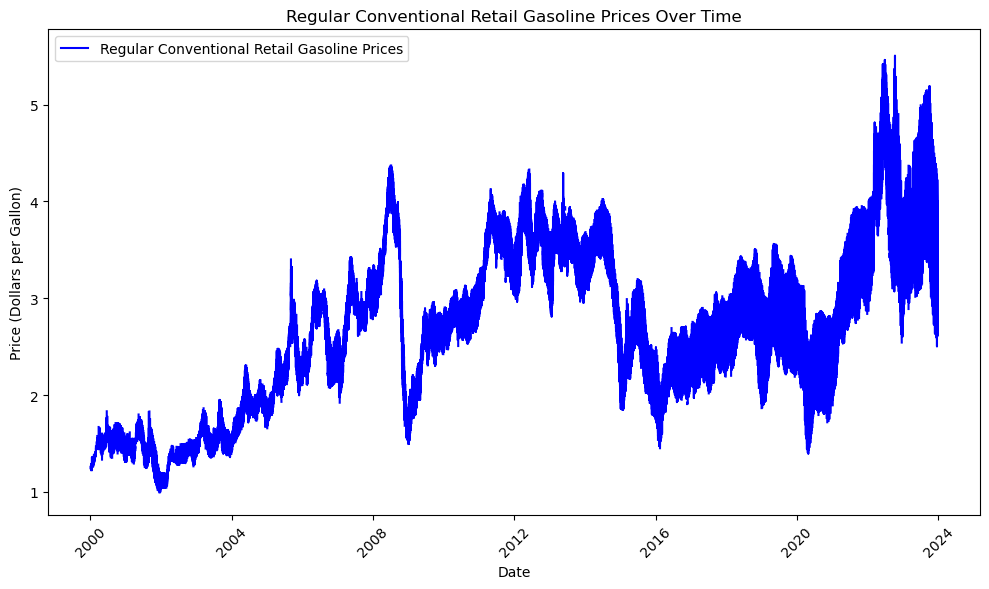

In [5]:
# Gas prices (regular conventional) over time
# Convert 'Date' column to datetime format
regular_conventional_df['Date'] = pd.to_datetime(regular_conventional_df['Date'])

# Sort the DataFrame based on the 'Date' column
regular_conventional_df = regular_conventional_df.sort_values('Date')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(regular_conventional_df['Date'], regular_conventional_df['Price'], label='Regular Conventional Retail Gasoline Prices', color='blue')
plt.title('Regular Conventional Retail Gasoline Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (Dollars per Gallon)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
sentiment_df = pd.read_csv("data/sentiment.csv")
wave_mapping = {
    1: 'Nov 2008',
    2: 'Jan 2010',
    3: 'Jun 2010',
    4: 'May 2011',
    5: 'Nov 2011',
    6: 'Mar 2012',
    7: 'Sep 2012',
    8: 'Apr 2013',
    9: 'Nov 2013',
    10: 'Apr 2014',
    11: 'Oct 2014',
    12: 'Mar 2015',
    13: 'Oct 2015',
    14: 'Mar 2016',
    15: 'Nov 2016',
    16: 'May 2017',
    17: 'Oct 2017',
    18: 'Mar 2018',
    19: 'Dec 2018',
    20: 'Apr 2019',
    21: 'Nov 2019',
    22: 'Apr 2020',
    23: 'Dec 2020',
    24: 'Mar 2021',
    25: 'Sep 2021',
    26: 'Apr 2022'
}

# Create a new column 'wave_date' in the dataframe 'df' mapping the 'wave' column to the corresponding month/years
sentiment_df['wave_date'] = sentiment_df['wave'].map(wave_mapping)
sentiment_df.head()
# Calculate the frequency of each response in the 'happening' column for each unique wave date
response_counts = sentiment_df.groupby('wave_date')['happening'].value_counts(normalize=True).unstack(fill_value=0)

# Rename the columns to reflect percentages
response_counts.columns = ['happening_refused', 'happening_no', 'happening_dont_know', 'happening_yes']

# Reorder the columns to match the requested order
response_counts = response_counts[['happening_yes', 'happening_dont_know', 'happening_no', 'happening_refused']]

response_counts.reset_index(inplace=True)
response_counts.head()

,wave_date,happening_yes,happening_dont_know,happening_no,happening_refused
0,Apr 2013,0.644976,0.194258,0.156938,0.003828
1,Apr 2014,0.640671,0.164857,0.193485,0.000987
2,Apr 2019,0.673896,0.156468,0.169636,0.000000
3,Apr 2020,0.726919,0.156463,0.116618,0.000000
4,Apr 2022,0.707269,0.160118,0.132613,0.000000


In [7]:
# Count the number of data points for each wave_date
data_points_per_wave = sentiment_df['wave_date'].value_counts().reset_index()
data_points_per_wave.columns = ['wave_date', 'data_point_count']
data_points_per_wave.sort_values(by='wave_date', inplace=True)
data_points_per_wave

,wave_date,data_point_count
13,Apr 2013,1045
19,Apr 2014,1013
4,Apr 2019,1291
16,Apr 2020,1029
18,Apr 2022,1018
11,Dec 2018,1114
15,Dec 2020,1036
23,Jan 2010,1001
17,Jun 2010,1024
21,Mar 2012,1008


In [8]:
# Calculate the frequency of each response in the 'reg_CO2_pollutant' column for each unique wave date
CO2_response_counts = sentiment_df.groupby('wave_date')['reg_CO2_pollutant'].value_counts(normalize=True).unstack(fill_value=0)

# Rename the columns to reflect the specific responses
CO2_response_counts.columns = ['reg_CO2_refused', 'reg_CO2_strongly_oppose', 'reg_CO2_somewhat_oppose', 'reg_CO2_somewhat_support', 'reg_CO2_strongly_support']

# Merge the new CO2 response counts into the existing response_counts dataframe
response_counts = response_counts.merge(CO2_response_counts, on='wave_date', how='left')

response_counts.head()

,wave_date,happening_yes,happening_dont_know,happening_no,happening_refused,reg_CO2_refused,reg_CO2_strongly_oppose,reg_CO2_somewhat_oppose,reg_CO2_somewhat_support,reg_CO2_strongly_support
0,Apr 2013,0.644976,0.194258,0.156938,0.003828,0.050718,0.121531,0.150239,0.459330,0.218182
1,Apr 2014,0.640671,0.164857,0.193485,0.000987,0.029615,0.118460,0.165844,0.446199,0.239882
2,Apr 2019,0.673896,0.156468,0.169636,0.000000,0.003873,0.114640,0.156468,0.432223,0.292796
3,Apr 2020,0.726919,0.156463,0.116618,0.000000,0.004859,0.083576,0.162293,0.406220,0.343052
4,Apr 2022,0.707269,0.160118,0.132613,0.000000,0.008841,0.112967,0.163065,0.421415,0.293713


In [9]:
# Calculate the frequency of each response in the 'fund_research' column for each unique wave date
fund_research_response_counts = sentiment_df.groupby('wave_date')['fund_research'].value_counts(normalize=True).unstack(fill_value=0)

# Rename the columns to reflect the specific responses for 'fund_research'
fund_research_response_counts.columns = ['fund_research_refused', 'fund_research_strongly_oppose', 'fund_research_somewhat_oppose', 'fund_research_somewhat_support', 'fund_research_strongly_support']

# Merge the new fund_research response counts into the existing response_counts dataframe
response_counts = response_counts.merge(fund_research_response_counts, on='wave_date', how='left')

response_counts.head()

,wave_date,happening_yes,happening_dont_know,happening_no,happening_refused,reg_CO2_refused,reg_CO2_strongly_oppose,reg_CO2_somewhat_oppose,reg_CO2_somewhat_support,reg_CO2_strongly_support,fund_research_refused,fund_research_strongly_oppose,fund_research_somewhat_oppose,fund_research_somewhat_support,fund_research_strongly_support
0,Apr 2013,0.644976,0.194258,0.156938,0.003828,0.050718,0.121531,0.150239,0.459330,0.218182,0.044976,0.112919,0.129187,0.436364,0.276555
1,Apr 2014,0.640671,0.164857,0.193485,0.000987,0.029615,0.118460,0.165844,0.446199,0.239882,0.031589,0.089832,0.109576,0.438302,0.330701
2,Apr 2019,0.673896,0.156468,0.169636,0.000000,0.003873,0.114640,0.156468,0.432223,0.292796,0.002324,0.067390,0.089853,0.446940,0.393493
3,Apr 2020,0.726919,0.156463,0.116618,0.000000,0.004859,0.083576,0.162293,0.406220,0.343052,0.004859,0.035957,0.092323,0.426628,0.440233
4,Apr 2022,0.707269,0.160118,0.132613,0.000000,0.008841,0.112967,0.163065,0.421415,0.293713,0.005894,0.097250,0.120825,0.396857,0.379175


In [10]:
# Convert 'wave_date' in response_counts to datetime to ensure proper merging
response_counts['wave_date'] = pd.to_datetime(response_counts['wave_date'], format='%b %Y')

# Convert 'Date' in month_gas to datetime
month_gas['Date'] = pd.to_datetime(month_gas['Date'])

# Merge 'Retail_Price' from month_gas into response_counts
response_counts = pd.merge(response_counts, month_gas[['Date', 'Retail_Price']], left_on='wave_date', right_on='Date', how='left')

# Drop the extra 'Date' column after merge
response_counts.drop(columns=['Date'], inplace=True)

response_counts.head()

,wave_date,happening_yes,happening_dont_know,happening_no,happening_refused,reg_CO2_refused,reg_CO2_strongly_oppose,reg_CO2_somewhat_oppose,reg_CO2_somewhat_support,reg_CO2_strongly_support,fund_research_refused,fund_research_strongly_oppose,fund_research_somewhat_oppose,fund_research_somewhat_support,fund_research_strongly_support,Retail_Price
0,2013-04-01,0.644976,0.194258,0.156938,0.003828,0.050718,0.121531,0.150239,0.459330,0.218182,0.044976,0.112919,0.129187,0.436364,0.276555,3.570
1,2013-04-01,0.644976,0.194258,0.156938,0.003828,0.050718,0.121531,0.150239,0.459330,0.218182,0.044976,0.112919,0.129187,0.436364,0.276555,3.930
2,2014-04-01,0.640671,0.164857,0.193485,0.000987,0.029615,0.118460,0.165844,0.446199,0.239882,0.031589,0.089832,0.109576,0.438302,0.330701,3.661
3,2014-04-01,0.640671,0.164857,0.193485,0.000987,0.029615,0.118460,0.165844,0.446199,0.239882,0.031589,0.089832,0.109576,0.438302,0.330701,3.964
4,2019-04-01,0.673896,0.156468,0.169636,0.000000,0.003873,0.114640,0.156468,0.432223,0.292796,0.002324,0.067390,0.089853,0.446940,0.393493,2.798


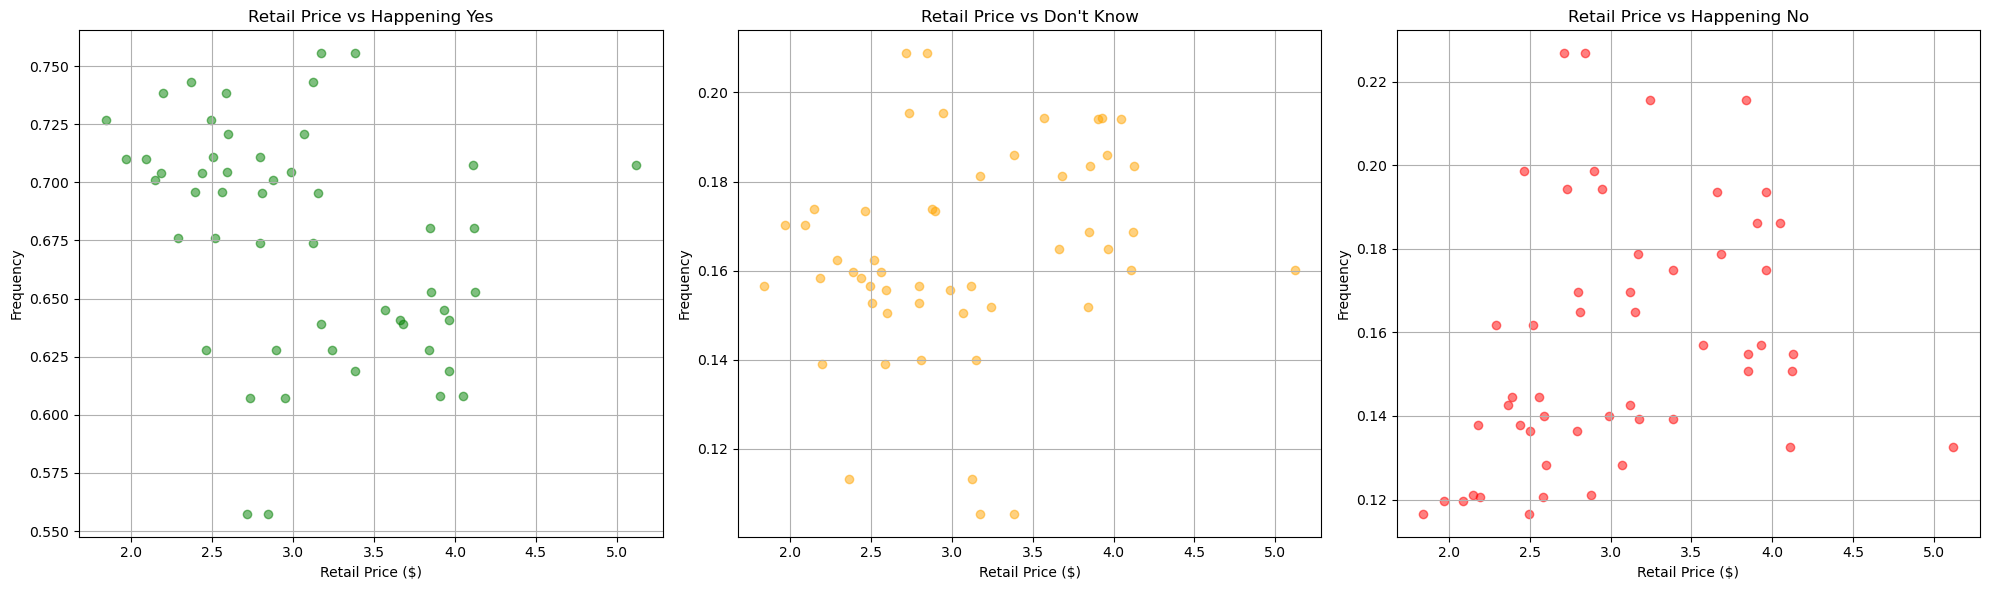

In [11]:
# Plot scatterplots for happening_yes, happening_dont_know, and happening_no along with Retail_Price

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Plot for happening_yes
axs[0].scatter(response_counts['Retail_Price'], response_counts['happening_yes'], color='green', alpha=0.5)
axs[0].set_title('Retail Price vs Happening Yes')
axs[0].set_xlabel('Retail Price ($)')
axs[0].set_ylabel('Frequency')
axs[0].grid(True)

# Plot for happening_dont_know
axs[1].scatter(response_counts['Retail_Price'], response_counts['happening_dont_know'], color='orange', alpha=0.5)
axs[1].set_title('Retail Price vs Don\'t Know')
axs[1].set_xlabel('Retail Price ($)')
axs[1].set_ylabel('Frequency')
axs[1].grid(True)

# Plot for happening_no
axs[2].scatter(response_counts['Retail_Price'], response_counts['happening_no'], color='red', alpha=0.5)
axs[2].set_title('Retail Price vs Happening No')
axs[2].set_xlabel('Retail Price ($)')
axs[2].set_ylabel('Frequency')
axs[2].grid(True)

plt.tight_layout()
plt.show()

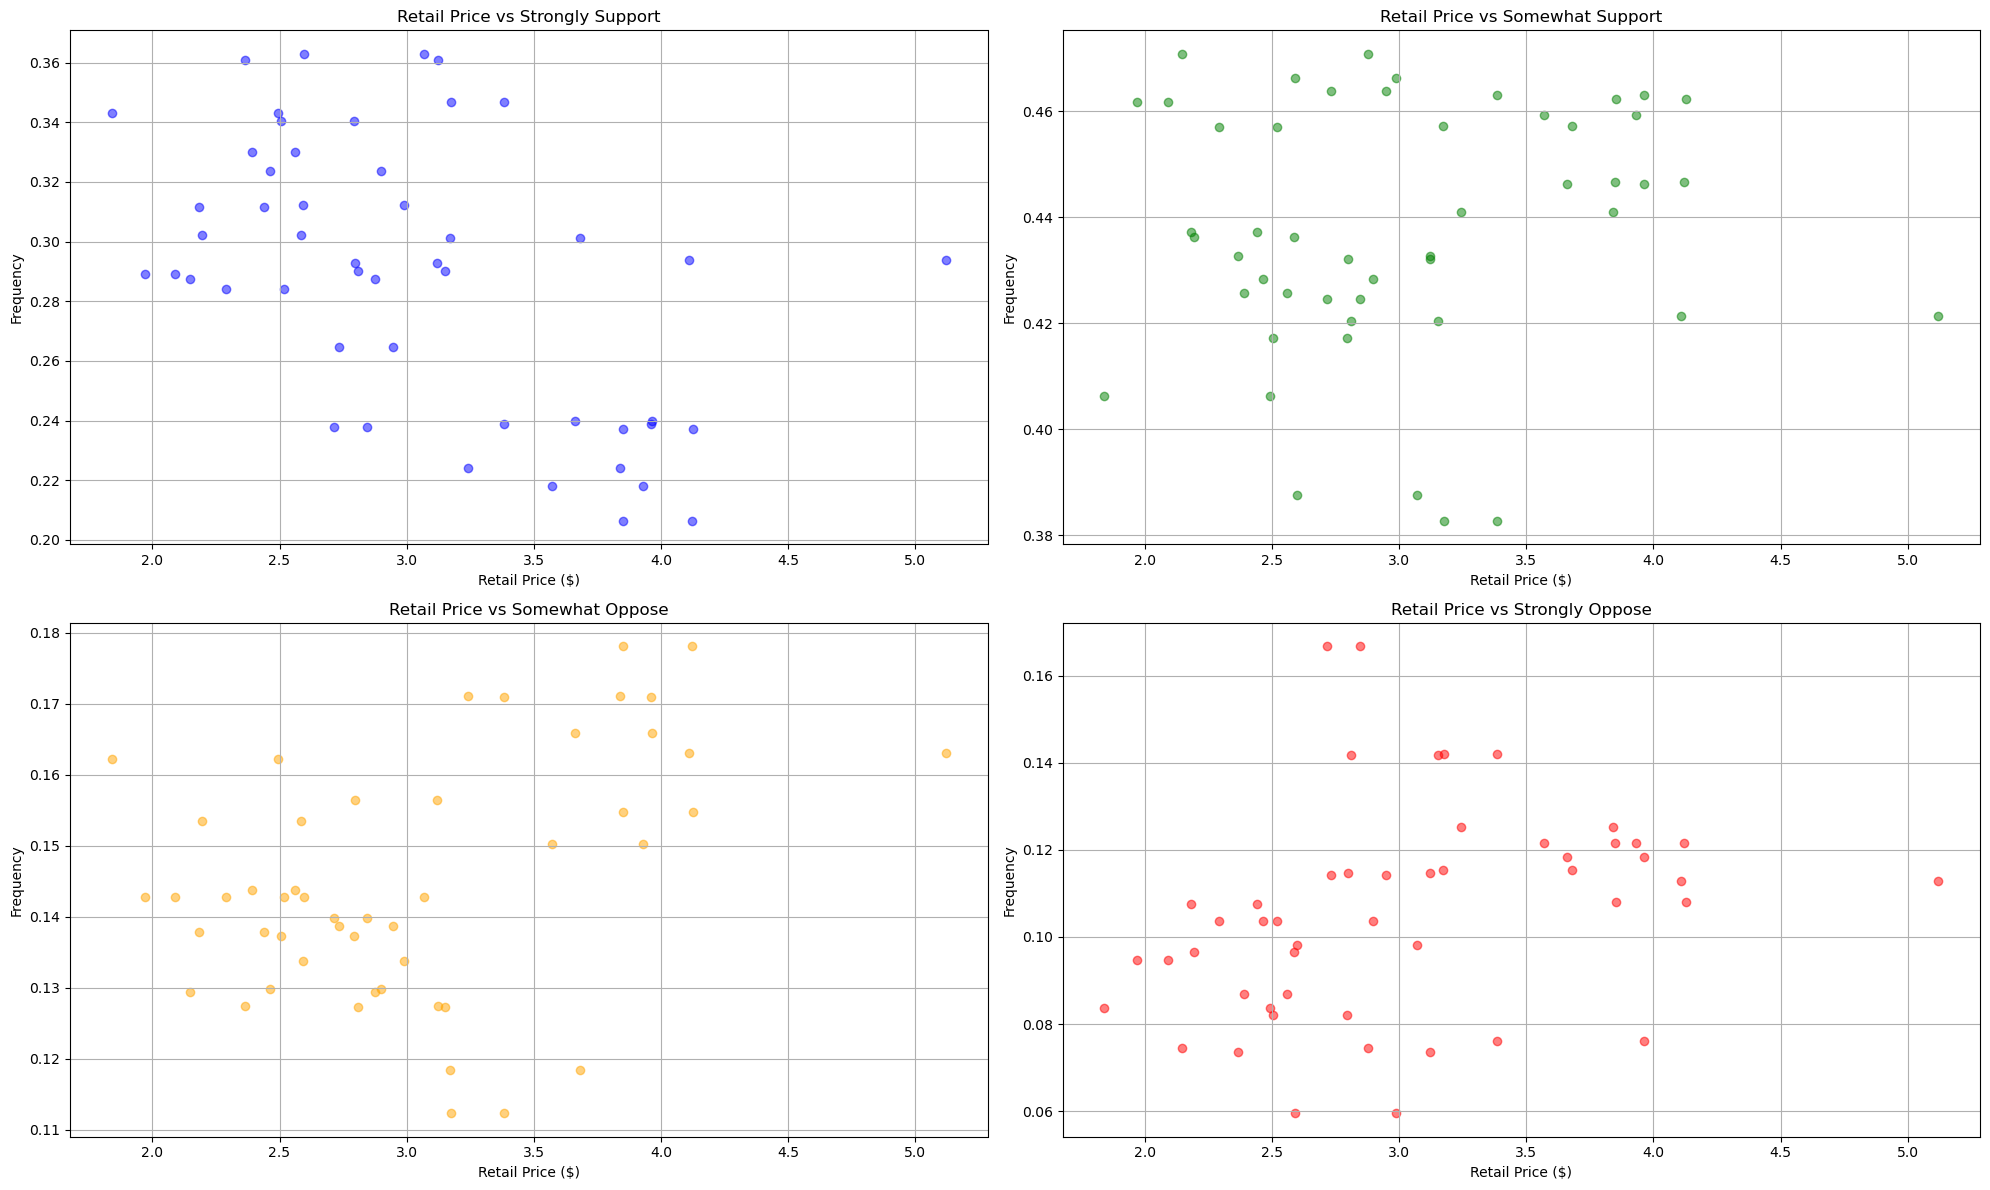

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12))

# Plot for reg_CO2_strongly_support
axs[0, 0].scatter(response_counts['Retail_Price'], response_counts['reg_CO2_strongly_support'], color='blue', alpha=0.5)
axs[0, 0].set_title('Retail Price vs Strongly Support')
axs[0, 0].set_xlabel('Retail Price ($)')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].grid(True)

# Plot for reg_CO2_somewhat_support
axs[0, 1].scatter(response_counts['Retail_Price'], response_counts['reg_CO2_somewhat_support'], color='green', alpha=0.5)
axs[0, 1].set_title('Retail Price vs Somewhat Support')
axs[0, 1].set_xlabel('Retail Price ($)')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].grid(True)

# Plot for reg_CO2_somewhat_oppose
axs[1, 0].scatter(response_counts['Retail_Price'], response_counts['reg_CO2_somewhat_oppose'], color='orange', alpha=0.5)
axs[1, 0].set_title('Retail Price vs Somewhat Oppose')
axs[1, 0].set_xlabel('Retail Price ($)')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].grid(True)

# Plot for reg_CO2_strongly_oppose
axs[1, 1].scatter(response_counts['Retail_Price'], response_counts['reg_CO2_strongly_oppose'], color='red', alpha=0.5)
axs[1, 1].set_title('Retail Price vs Strongly Oppose')
axs[1, 1].set_xlabel('Retail Price ($)')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


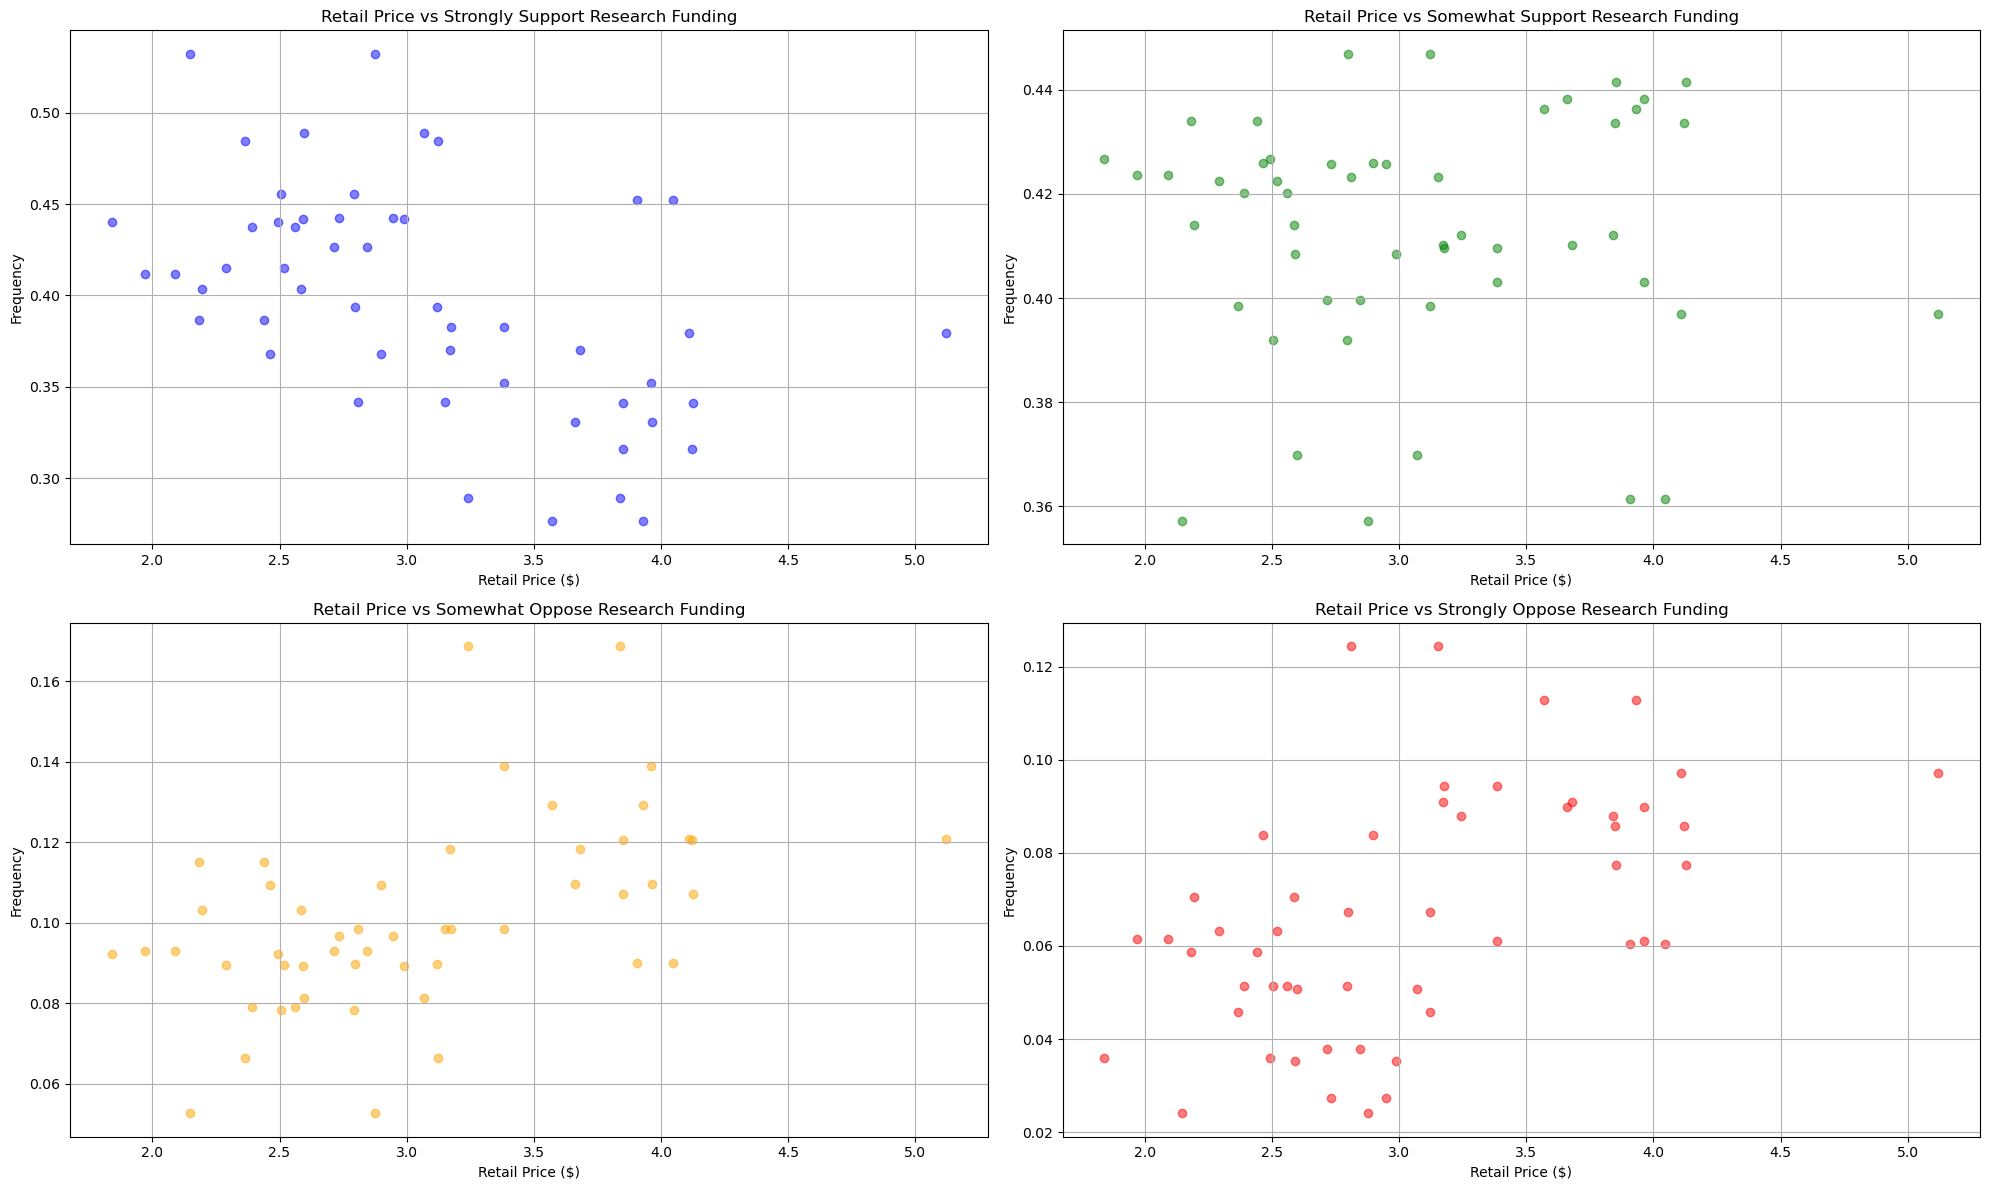

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12))

# Plot for fund_research_strongly_support
axs[0, 0].scatter(response_counts['Retail_Price'], response_counts['fund_research_strongly_support'], color='blue', alpha=0.5)
axs[0, 0].set_title('Retail Price vs Strongly Support Research Funding')
axs[0, 0].set_xlabel('Retail Price ($)')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].grid(True)

# Plot for fund_research_somewhat_support
axs[0, 1].scatter(response_counts['Retail_Price'], response_counts['fund_research_somewhat_support'], color='green', alpha=0.5)
axs[0, 1].set_title('Retail Price vs Somewhat Support Research Funding')
axs[0, 1].set_xlabel('Retail Price ($)')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].grid(True)

# Plot for fund_research_somewhat_oppose
axs[1, 0].scatter(response_counts['Retail_Price'], response_counts['fund_research_somewhat_oppose'], color='orange', alpha=0.5)
axs[1, 0].set_title('Retail Price vs Somewhat Oppose Research Funding')
axs[1, 0].set_xlabel('Retail Price ($)')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].grid(True)

# Plot for fund_research_strongly_oppose
axs[1, 1].scatter(response_counts['Retail_Price'], response_counts['fund_research_strongly_oppose'], color='red', alpha=0.5)
axs[1, 1].set_title('Retail Price vs Strongly Oppose Research Funding')
axs[1, 1].set_xlabel('Retail Price ($)')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

R^2 value for support regulation of CO2 emissions: 0.3377


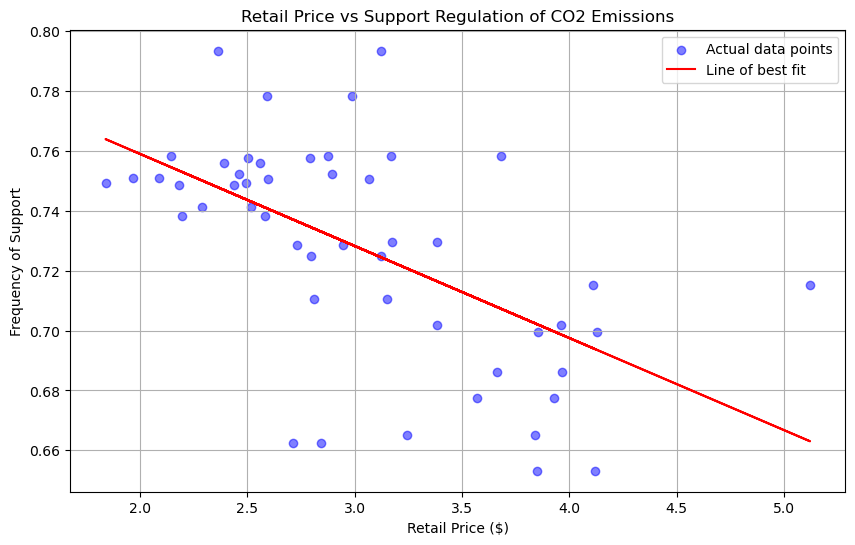

In [14]:
# Prepare data for linear regression
# Filter out rows where 'reg_CO2_somewhat_support' and 'reg_CO2_strongly_support' are both 0 to avoid skewing the model with zero y values
filtered_response_counts = response_counts[(response_counts['reg_CO2_somewhat_support'] != 0) | (response_counts['reg_CO2_strongly_support'] != 0)]
X = filtered_response_counts['Retail_Price'].values.reshape(-1, 1)  # Feature matrix
y_support = filtered_response_counts['reg_CO2_somewhat_support'].values + filtered_response_counts['reg_CO2_strongly_support'].values  # Target variable
mask = ~np.isnan(y_support)
y_support = y_support[mask]
X = X[mask]

# Create a linear regression model
model_support = LinearRegression()
model_support.fit(X, y_support)

# Predict y values
y_pred_support = model_support.predict(X)

# Calculate R^2 value
r2_support = model_support.score(X, y_support)
print(f"R^2 value for support regulation of CO2 emissions: {r2_support:.4f}")

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(X, y_support, color='blue', alpha=0.5, label='Actual data points')
ax.plot(X, y_pred_support, color='red', label='Line of best fit')
ax.set_title('Retail Price vs Support Regulation of CO2 Emissions')
ax.set_xlabel('Retail Price ($)')
ax.set_ylabel('Frequency of Support')
ax.legend()
plt.grid(True)
plt.show()


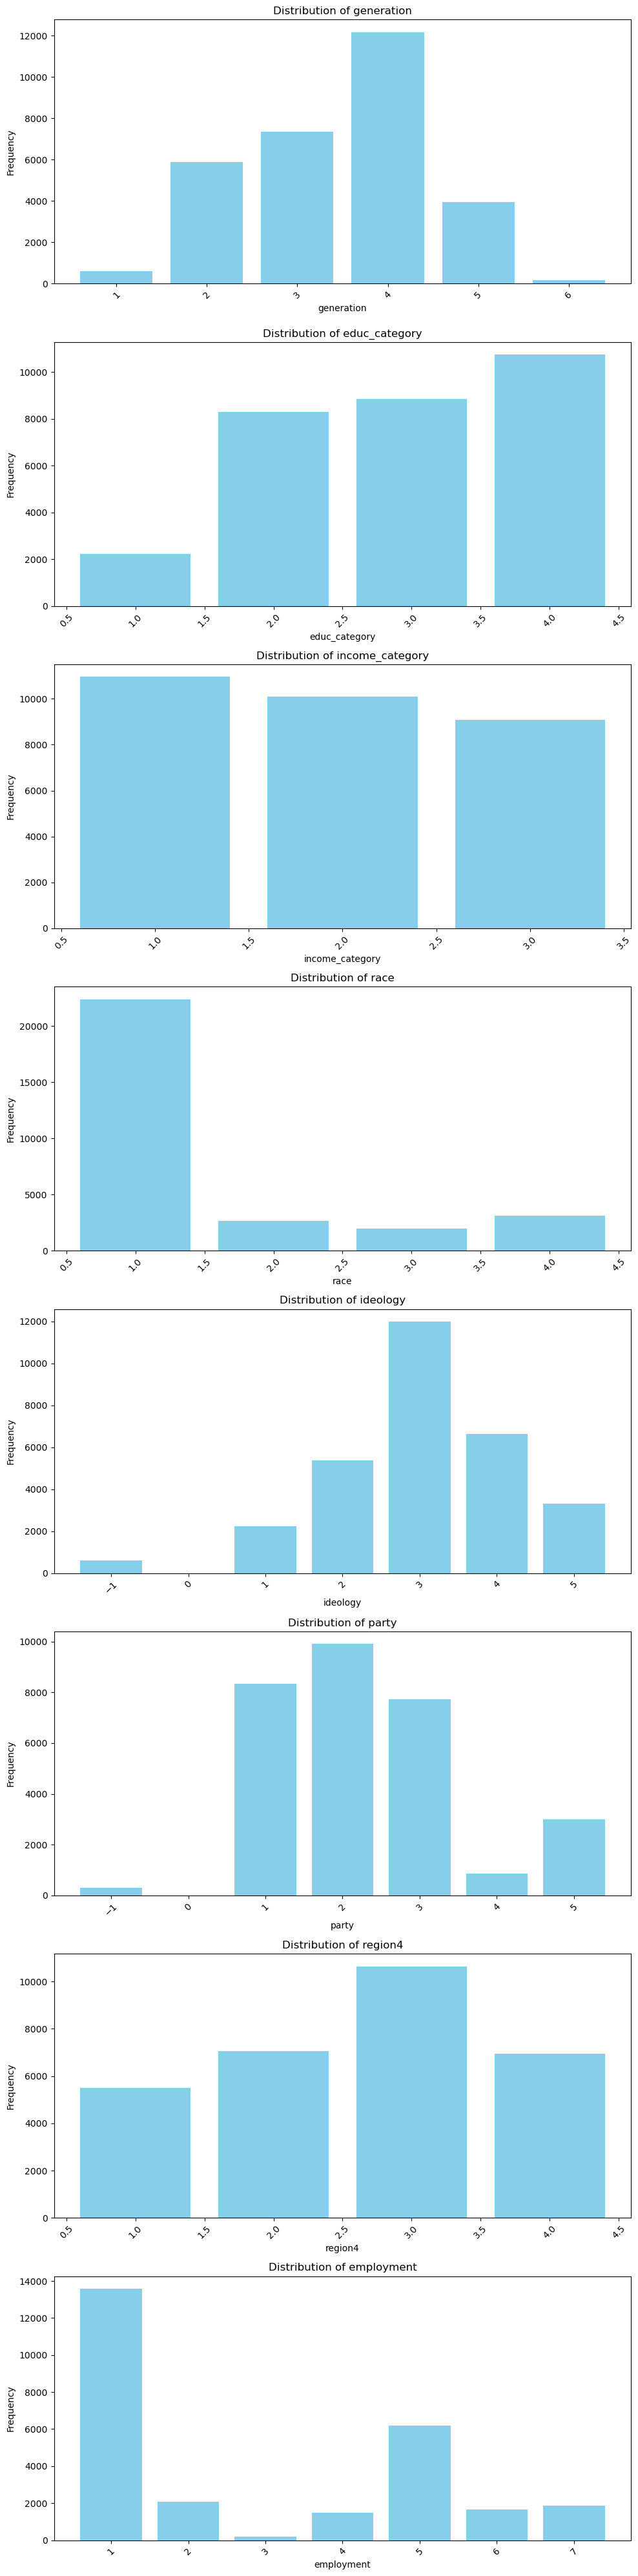

In [15]:
# Assuming 'original_dataset' is a DataFrame containing the specified columns
# and is already loaded in the environment.

columns_of_interest = ['generation', 'educ_category', 'income_category', 'race', 'ideology', 'party', 'region4', 'employment']
fig, axs = plt.subplots(len(columns_of_interest), 1, figsize=(10, 5 * len(columns_of_interest)))

for i, column in enumerate(columns_of_interest):
    # Count the occurrences of each category in the column
    value_counts = sentiment_df[column].value_counts()
    
    # Plotting the bar graph
    axs[i].bar(value_counts.index, value_counts.values, color='skyblue')
    axs[i].set_title(f'Distribution of {column}')
    axs[i].set_ylabel('Frequency')
    axs[i].set_xlabel(column)
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [16]:
# Splitting the data into employed and unemployed based on new criteria
employed_df = sentiment_df[sentiment_df['employment'].isin([1, 2])]
unemployed_df = sentiment_df[sentiment_df['employment'].isin([3, 4, 5, 6, 7])]
employed_df

,case_ID,wave,year,weight_wave,weight_aggregate,happening,cause_original,cause_other_text,cause_recoded,sci_consensus,...,house_head,house_size,house_ages0to1,house_ages2to5,house_ages6to12,house_ages13to17,house_ages18plus,house_type,house_own,wave_date
4,7.0,1.0,1.0,1.2900,0.644106,3.0,1.0,NaN,6.0,2.0,...,2.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,Nov 2008
5,8.0,1.0,1.0,2.5600,1.278226,2.0,2.0,NaN,4.0,2.0,...,2.0,3.0,0.0,0.0,1.0,0.0,2.0,2.0,1.0,Nov 2008
6,9.0,1.0,1.0,0.2300,0.114841,3.0,1.0,NaN,6.0,2.0,...,2.0,2.0,0.0,0.0,0.0,0.0,2.0,3.0,2.0,Nov 2008
7,11.0,1.0,1.0,0.8200,0.409432,1.0,1.0,NaN,6.0,3.0,...,2.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,Nov 2008
8,12.0,1.0,1.0,0.3800,0.189737,1.0,4.0,NaN,3.0,2.0,...,2.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,Nov 2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,47048.0,23.0,12.0,2.5675,2.677784,2.0,2.0,-1,4.0,2.0,...,2.0,6.0,1.0,1.0,2.0,0.0,2.0,4.0,2.0,Dec 2020
27071,47049.0,23.0,12.0,1.2261,1.278765,3.0,1.0,-1,6.0,4.0,...,2.0,2.0,0.0,0.0,0.0,0.0,2.0,3.0,2.0,Dec 2020
27072,47050.0,23.0,12.0,1.4181,1.479013,3.0,3.0,I don't know what is causing it,1.0,2.0,...,1.0,5.0,0.0,0.0,0.0,2.0,3.0,1.0,1.0,Dec 2020
27073,47051.0,23.0,12.0,1.6022,1.671020,3.0,1.0,-1,6.0,4.0,...,1.0,3.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,Dec 2020


In [17]:
employed_counts = response_counts[['wave_date', 'Retail_Price']].copy()
unemployed_counts = response_counts[['wave_date', 'Retail_Price']].copy()

In [18]:
# Calculate the frequency of each response in the 'reg_CO2_pollutant' column for each unique wave date
CO2_response_counts = employed_df.groupby('wave_date')['reg_CO2_pollutant'].value_counts(normalize=True).unstack(fill_value=0)

# Rename the columns to reflect the specific responses
CO2_response_counts.columns = ['reg_CO2_refused', 'reg_CO2_strongly_oppose', 'reg_CO2_somewhat_oppose', 'reg_CO2_somewhat_support', 'reg_CO2_strongly_support']

# Ensure 'wave_date' in both DataFrames is of the same type for successful merge
employed_counts['wave_date'] = pd.to_datetime(employed_counts['wave_date'])
CO2_response_counts.reset_index(inplace=True)
CO2_response_counts['wave_date'] = pd.to_datetime(CO2_response_counts['wave_date'])

# Merge the new CO2 response counts into the existing response_counts dataframe using pd.concat to avoid dtype mismatch error
employed_counts = pd.merge(employed_counts, CO2_response_counts, on='wave_date', how='left')
employed_counts.head()

/var/folders/xp/ycg8s5194736y0vn0h3_t5dm0000gn/T/ipykernel_28953/1955940276.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  CO2_response_counts['wave_date'] = pd.to_datetime(CO2_response_counts['wave_date'])


,wave_date,Retail_Price,reg_CO2_refused,reg_CO2_strongly_oppose,reg_CO2_somewhat_oppose,reg_CO2_somewhat_support,reg_CO2_strongly_support
0,2013-04-01,3.570,0.047452,0.126538,0.163445,0.437610,0.224956
1,2013-04-01,3.930,0.047452,0.126538,0.163445,0.437610,0.224956
2,2014-04-01,3.661,0.034799,0.122711,0.170330,0.441392,0.230769
3,2014-04-01,3.964,0.034799,0.122711,0.170330,0.441392,0.230769
4,2019-04-01,2.798,0.002497,0.111111,0.158552,0.441948,0.285893


In [19]:
# Calculate the frequency of each response in the 'reg_CO2_pollutant' column for each unique wave date for unemployed individuals
CO2_response_counts_unemployed = unemployed_df.groupby('wave_date')['reg_CO2_pollutant'].value_counts(normalize=True).unstack(fill_value=0)

# Rename the columns to reflect the specific responses for unemployed individuals
CO2_response_counts_unemployed.columns = ['reg_CO2_refused', 'reg_CO2_strongly_oppose', 'reg_CO2_somewhat_oppose', 'reg_CO2_somewhat_support', 'reg_CO2_strongly_support']

# Ensure 'wave_date' in both DataFrames is of the same type for successful merge
unemployed_counts['wave_date'] = pd.to_datetime(unemployed_counts['wave_date'])
CO2_response_counts_unemployed.reset_index(inplace=True)
CO2_response_counts_unemployed['wave_date'] = pd.to_datetime(CO2_response_counts_unemployed['wave_date'])

# Merge the new CO2 response counts for unemployed individuals into the existing response_counts dataframe using pd.concat to avoid dtype mismatch error
unemployed_counts = pd.merge(unemployed_counts, CO2_response_counts_unemployed, on='wave_date', how='left')
unemployed_counts.head()

/var/folders/xp/ycg8s5194736y0vn0h3_t5dm0000gn/T/ipykernel_28953/2155828623.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  CO2_response_counts_unemployed['wave_date'] = pd.to_datetime(CO2_response_counts_unemployed['wave_date'])


,wave_date,Retail_Price,reg_CO2_refused,reg_CO2_strongly_oppose,reg_CO2_somewhat_oppose,reg_CO2_somewhat_support,reg_CO2_strongly_support
0,2013-04-01,3.570,0.054622,0.115546,0.134454,0.485294,0.210084
1,2013-04-01,3.930,0.054622,0.115546,0.134454,0.485294,0.210084
2,2014-04-01,3.661,0.023555,0.113490,0.160600,0.451820,0.250535
3,2014-04-01,3.964,0.023555,0.113490,0.160600,0.451820,0.250535
4,2019-04-01,2.798,0.006122,0.120408,0.153061,0.416327,0.304082


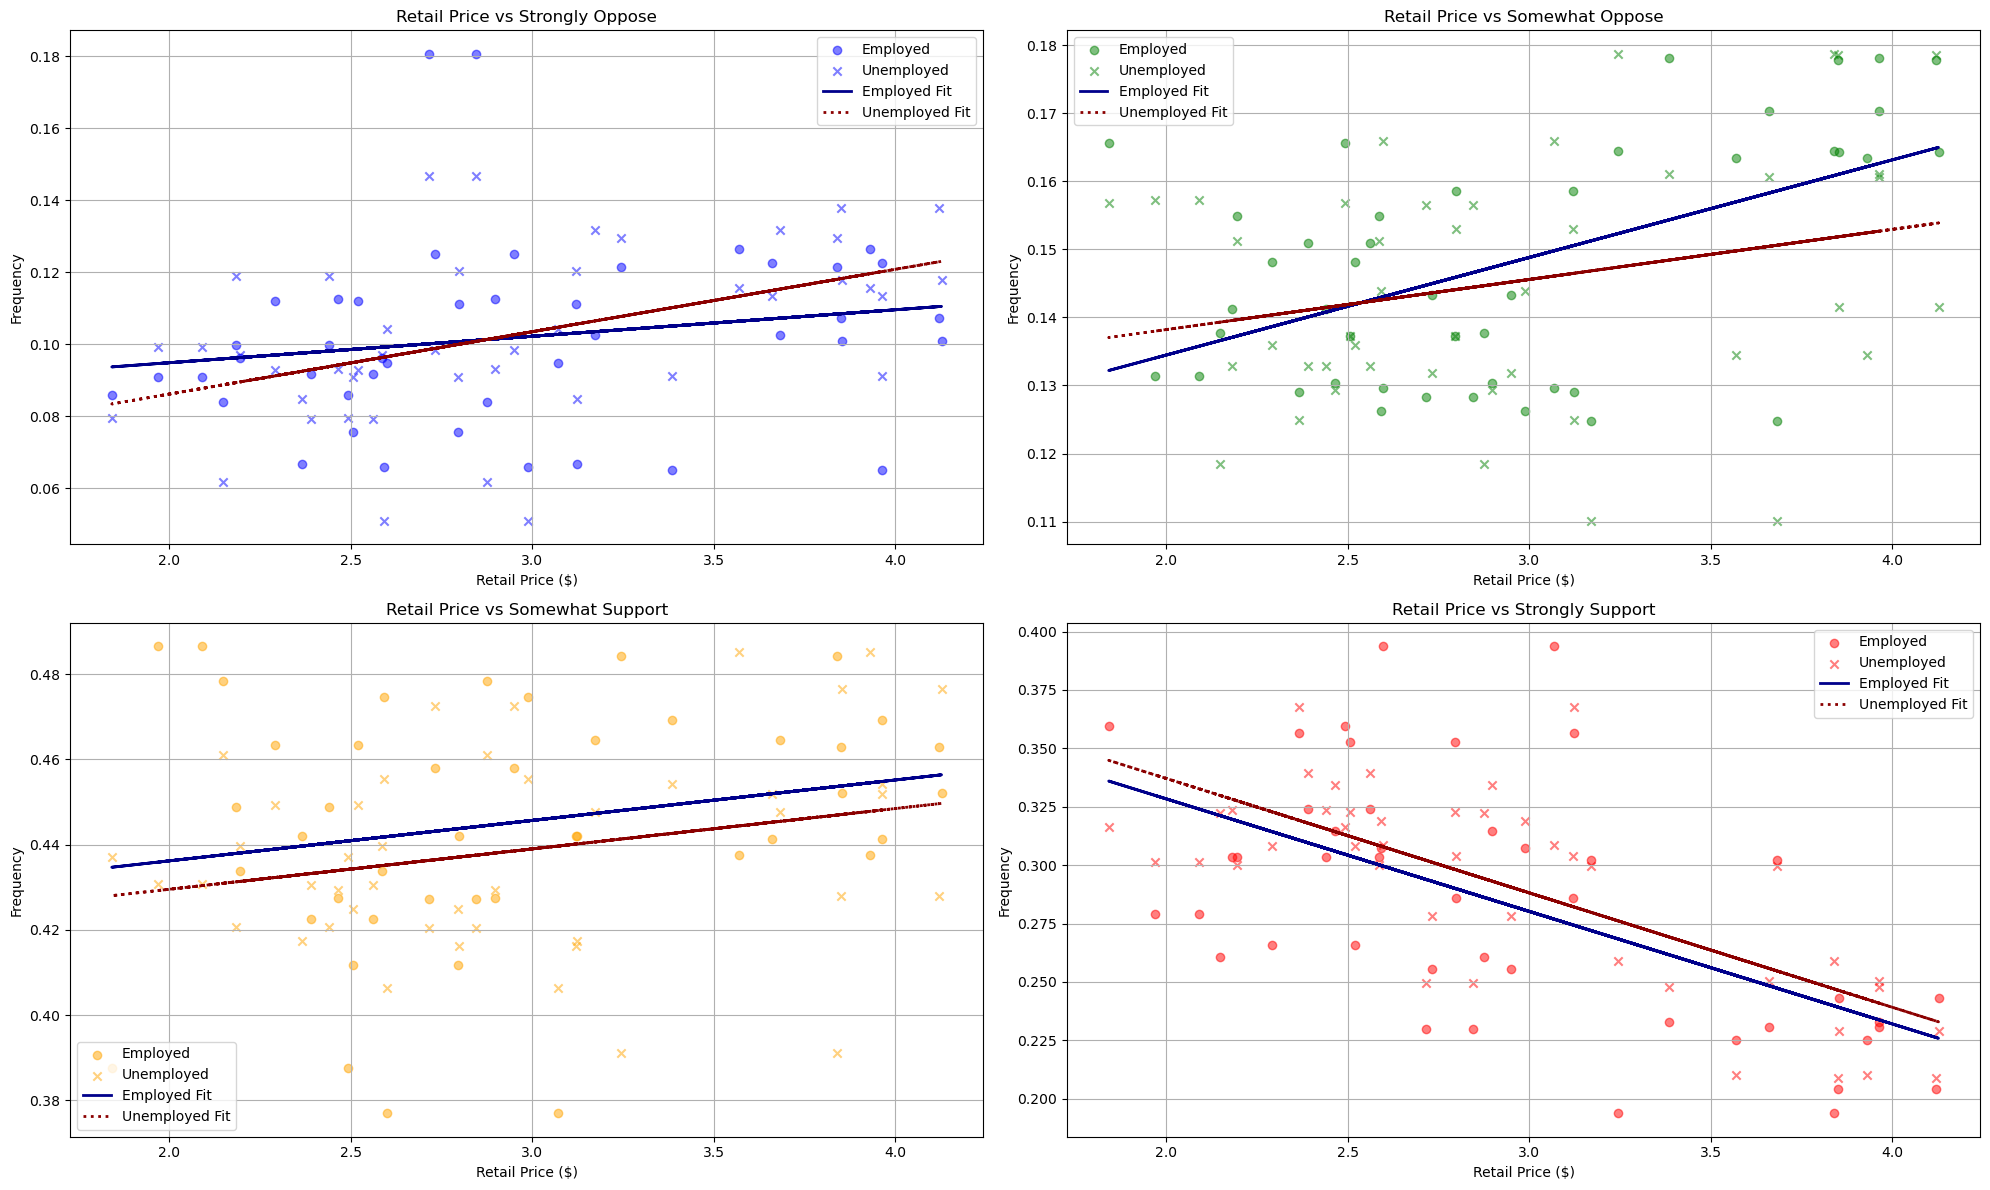

In [29]:
# Prepare data for plotting
sentiments = ['reg_CO2_strongly_oppose', 'reg_CO2_somewhat_oppose', 'reg_CO2_somewhat_support', 'reg_CO2_strongly_support']

fig, axs = plt.subplots(2, 2, figsize=(20, 12))

colors = ['blue', 'green', 'orange', 'red']
titles = ['Strongly Oppose', 'Somewhat Oppose', 'Somewhat Support', 'Strongly Support']
for i, sentiment in enumerate(sentiments):
    row = i // 2
    col = i % 2
    employed_no_nan = employed_counts.dropna(subset=['Retail_Price', sentiment])
    unemployed_no_nan = unemployed_counts.dropna(subset=['Retail_Price', sentiment])
    # Plotting scatter for employed
    axs[row, col].scatter(employed_no_nan['Retail_Price'], employed_no_nan[sentiment], color=colors[i], alpha=0.5, label='Employed')
    # Plotting scatter for unemployed
    axs[row, col].scatter(unemployed_no_nan['Retail_Price'], unemployed_no_nan[sentiment], color=colors[i], alpha=0.5, marker='x', label='Unemployed')
    # Sorting values for line of best fit plotting is not needed as numpy's polyfit function does not require sorted arrays
    # Adding line of best fit for employed
    m, b = np.polyfit(employed_no_nan['Retail_Price'], employed_no_nan[sentiment], 1)
    axs[row, col].plot(employed_no_nan['Retail_Price'], m*employed_no_nan['Retail_Price'] + b, color='darkblue', linewidth=2, label='Employed Fit')
    # Adding line of best fit for unemployed
    m_u, b_u = np.polyfit(unemployed_no_nan['Retail_Price'], unemployed_no_nan[sentiment], 1)
    axs[row, col].plot(unemployed_no_nan['Retail_Price'], m_u*unemployed_no_nan['Retail_Price'] + b_u, color='darkred', linewidth=2, linestyle=':', label='Unemployed Fit')
    axs[row, col].set_title(f'Retail Price vs {titles[i]}')
    axs[row, col].set_xlabel('Retail Price ($)')
    axs[row, col].set_ylabel('Frequency')
    axs[row, col].grid(True)
    axs[row, col].legend()

plt.tight_layout()
plt.show()